# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 0: Load The Data

In [25]:
import importlib
import traffic_data
import numpy as np
from IPython.display import display, Image, HTML

_ = importlib.reload(traffic_data)

In [26]:
train_file = "/Users/navsie/Documents/traffic-signs-data/train.p"
test_file = "/Users/navsie/Documents/traffic-signs-data/test.p"

X_train, y_train, X_test, y_test = traffic_data.read(train_file, test_file)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [27]:


# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of an traffic sign image?
image_shape = X_train.shape[1:]

# Unique classes/labels there are in the dataset.
n_classes = np.unique(np.append(y_train, y_test)).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [28]:
import csv

signames = [None] * n_classes
signames_path = "data/signames.csv"
with open(signames_path) as signame_file:
    reader = csv.DictReader(signame_file)
    for row in reader:
        signames[int(row["ClassId"])] = row["SignName"]

#### Training and testing dataset description

Let's explore dataset which has been loaded.
You can find images of each class below. I didn't try to select perfect images from dataset, so that you could see diversity of the traffic sign samples and their quality. Some examples are even hardly recognizable, e.g. traffic sign with class index **19**, because of its low brightness. Not only color and scale distortions catch the eye, but a part of classes are symmetrically equal. E.g. classes **36** and **37**, if you flip one of them horizontally you will get another one class.

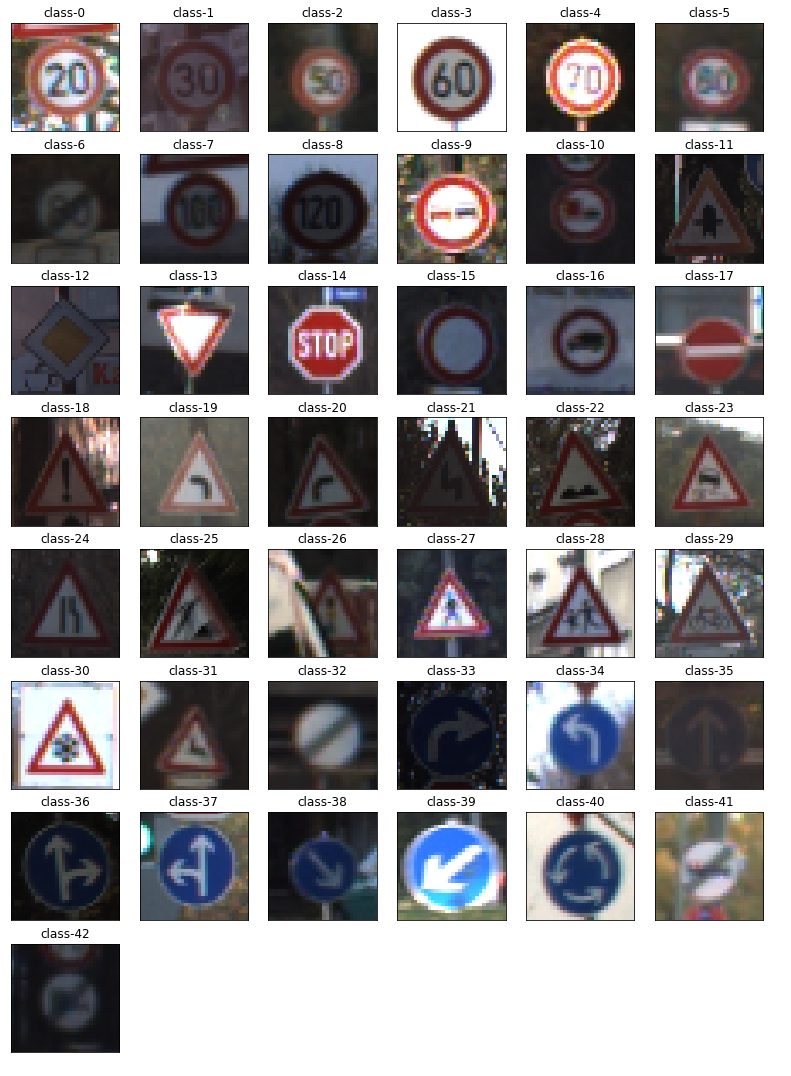

In [29]:
import matplotlib.pyplot as plt
import textwrap
import cv2

%matplotlib inline

sorted_indices = np.argsort(y_train)
diff = np.diff(np.take(y_train, sorted_indices))

class_first_indices = np.append([0], np.add(np.where(diff > 0), 1))

# Stride number is a shift of indices of the class in sorted array of indexes
# Tuning it you can find samples with better quality
stride = 125
class_first_indices_with_shift = class_first_indices + stride
class_indices = np.take(sorted_indices, class_first_indices_with_shift)

# We expect that number of classes in training set is equal to
# total number of classes
assert(class_indices.size == n_classes)

class_images = X_train[class_indices]
class_types = y_train[class_indices]

num_classes = len(class_types)
cols = 6
rows = num_classes // cols + num_classes % cols
figsize = (10, 15)

def annotate(i):
    return "class-{0}".format(str(i))

class_names = list(map(lambda i: annotate(i), class_types))

def show_images(ims, lbl, nrows, ncols, figsize):
    n = len(lbl)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, squeeze=True)
    for r in np.arange(rows):
        for c in np.arange(cols):
            i = r * cols + c
            if i >= n:
                axes[r][c].axis('off')
                continue
            axes[r][c].imshow(ims[i])
            axes[r][c].set_title(lbl[i])
            axes[r][c].get_xaxis().set_visible(False)
            axes[r][c].get_yaxis().set_visible(False)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, left=-0.1)
    
show_images(class_images, class_names, rows, cols, figsize)

**NOTE:**

Before start learning process, it is important to figure out the distribution of labels in training dataset. Doing so, we will be aware of skewness and bias of dataset to certain labels. Bear in mind that we keep testing dataset in the background as we will not use it during training sessions.
The **histograms** and **tables of label distribution** shows that some classes appear more frequently than others and it can bring instability into future model. Top

In [30]:
import pandas as pd

# Pandas sort function emits annoying warning message that columns
# argument is depricated. This trick lets shut it up.
import warnings
warnings.filterwarnings('ignore')

descr_train = traffic_data.label_description(y_train)
descr_test = traffic_data.label_description(y_test)

css = """
div.cell:nth-child(5) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(css))

pd.options.display.float_format = '{:.3%}'.format
display(descr_train, descr_test)

class  count  percentage
0       2   2250      5.738%
1       1   2220      5.662%
2      13   2160      5.509%
3      12   2100      5.356%
4      38   2070      5.279%
5      10   2010      5.126%
6       4   1980      5.050%
7       5   1860      4.744%
8      25   1500      3.826%
9       9   1470      3.749%
10      7   1440      3.673%
11      3   1410      3.596%
12      8   1410      3.596%
13     11   1320      3.367%
14     35   1200      3.061%
15     18   1200      3.061%
16     17   1110      2.831%
17     31    780      1.989%
18     14    780      1.989%
19     33    689      1.757%
20     15    630      1.607%
21     26    600      1.530%
22     28    540      1.377%
23     23    510      1.301%
24     30    450      1.148%
25     16    420      1.071%
26     34    420      1.071%
27      6    420      1.071%
28     36    390      0.995%
29     22    390      0.995%
30     40    360      0.918%
31     20    360      0.918%
32     21    330      0.842%
33     39    300      0.765%
34     29    270      0.689%
35     24    270      0.689%
36     41    240      0.612%
37     42    240      0.612%
38     32    240      0.612%
39     27    240      0.612%
40     37    210      0.536%
41     19    210      0.536%
42      0    210      0.536%

class  count  percentage
0       2    750      5.938%
1      13    720      5.701%
2       1    720      5.701%
3      38    690      5.463%
4      12    690      5.463%
5      10    660      5.226%
6       4    660      5.226%
7       5    630      4.988%
8      25    480      3.800%
9       9    480      3.800%
10      7    450      3.563%
11      8    450      3.563%
12      3    450      3.563%
13     11    420      3.325%
14     18    390      3.088%
15     35    390      3.088%
16     17    360      2.850%
17     14    270      2.138%
18     31    270      2.138%
19     15    210      1.663%
20     33    210      1.663%
21     26    180      1.425%
22     30    150      1.188%
23     23    150      1.188%
24     28    150      1.188%
25      6    150      1.188%
26     16    150      1.188%
27     34    120      0.950%
28     36    120      0.950%
29     22    120      0.950%
30     39     90      0.713%
31     40     90      0.713%
32     21     90      0.713%
33     42     90      0.713%
34     29     90      0.713%
35     24     90      0.713%
36     20     90      0.713%
37     32     60      0.475%
38     27     60      0.475%
39     37     60      0.475%
40     19     60      0.475%
41     41     60      0.475%
42      0     60      0.475%

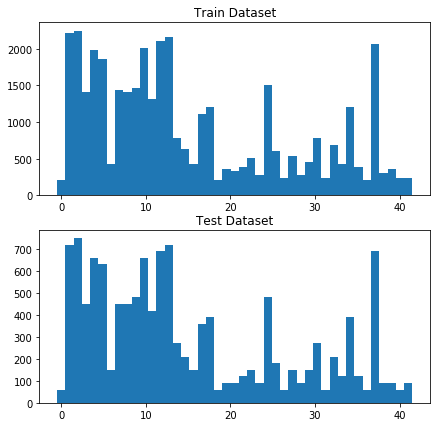

In [31]:
_, ax = plt.subplots(nrows=2, figsize=(7,7))
ax[0].hist(y_train, n_classes, normed=0, histtype='bar', align='left')
ax[1].hist(y_test, n_classes, normed=0, histtype='bar', align='left')
ax[0].set_title("Train Dataset")
_ = ax[1].set_title("Test Dataset")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have 
completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I considered two options to preprocess data: **scale image pixels for whole image** and **scale image pixels per each channel**. It is well known that **deep learning** are sensitive to the input's features distribution, in other words if your input is not standardised and some features are relatively high and others low, they will affect loss function differently and not proportionally. Hence domination of some features will bring a lot of fluctuation to learning process into your network.
I focused on standard normalization of image and didn't use normalization per channel. I think that pixel should be scaled with respective to whole image not channel. The dangerous is that a channel of an image can have stronger intensities than others channels. Meanwhile absolutely different image with same class will have another strong channel. As I think, such situations can entail to weak learning of neural network and provides less stability into backpropagation algorithm.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


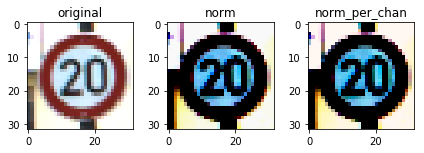

In [32]:
def immean(img):
    return np.mean(img)

def imstd(img):
    num = 1.0
    for x in img.shape: num *= x
    return max(np.std(img), 1.0/(np.sqrt(num)))

def norm(img):
    return (img - immean(img)) / imstd(img)

def immean_per_channel(img):
    return np.mean(img, axis=(0,1))

def imstd_per_channel(img):
    num = img.shape[0] * img.shape[1]
    sqrts = [1.0/np.sqrt(num)] * img.shape[2]
    stds = np.std(img, axis=(0,1))
    return list(map(max, zip(stds, sqrts)))

def norm_per_channel(img):
    return (img - immean_per_channel(img)) / imstd_per_channel(img)

image_index = 128
train_image = X_train[image_index]

train_image = np.array(train_image, dtype=np.float32)
norm_chan_image = norm_per_channel(train_image)
norm_image = norm(train_image)

examples = [("original", np.uint8(train_image)),
            ("norm", norm_image),
            ("norm_per_chan", norm_chan_image)]

_, axes = plt.subplots(ncols=len(examples), squeeze=True)
for i, ax in enumerate(axes):
    ax.set_title(examples[i][0])
    ax.imshow(examples[i][1])

plt.tight_layout()

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

**Describe how you set up the training, validation and testing data for your model**

Earlier I mentioned that _Traffic Sign Data_ is very unbalanced dataset. Fraction of top-10 most frequent classes is about `5.8%`-`3.7%`, whilst on the contrary side of the dataset statistic, the percentage of infrequent classes is `0.5%`-`0.7%`. This is huge gap and such poor *training* dataset will drastically reduce accuracy of the classificator on test data, because during the process of learning the optimization algorithm will tweak weights according to most seen classes and eventually the model will not be good enough tuned for rare classes.

There are two way to overcome this issue: **augment data** and use **weighted softmax**.
The weighted softmax uses inverted frequencies of classes to correct inference probabilities. Usually, it gives poor results, so I decided to go with augmentation approch.

Besides that, good augmentation method can make your dataset not only more balanced, but it introduces some noise. So that your model can benefits from it and became more reliable on new dataset.

I splitted augmented data on validation and training datasets by `sklearn` package. In fact, I took 1/10 part of augmentated images to validation dataset and rest of them put into training bag. I didn't modify test dataset at all. The code is hidden in `traffic_data.save_for_training(...)` function:

> xtrain, ytrain = shuffle(xtrain, ytrain)  
> xt, xv, yt, yv = train_test_split(xtrain, ytrain, test_size=valid_size)

**How did you generate the data?**

I wrote a small python `imagerich` module based on `skimage` package to augment _Traffic Sign Dataset_.
`imagerich` can add random oscillations to source image, for e.g.:

- Add noise (gaussian, speckle)
- Rotate image
- Change intensity range
- Scale image
- Flip image (horizontally, ~~vertically~~)
- Translate image among axes
- Whenever image rotated, zoomed out and etc. The boundaries can be filled with some constant value or replaced with reflection of an image, wrapping.

I wrapped up `imagerich` library with `traffic_data` module in `augment` function. It helps to abstract from jyputer notebook and work outside of it.

The steps I have done to augment data:

1. At first I determined the target size of augmented dataset.
2. `traffic_data.augment()` looks at dataset description and defines new probabilities for classes. It assigns higher probability to infrequent classes and in this manner frequent classes get lower probabilities. 
3. Then `traffic_data.augment()` selects randomly images from training dataset according chosen distribution of classes and applies `imagerich` library to generate new ones.

**What are the differences in the new dataset (with generated data) from the original dataset? **

Using `3` step approch mentioned earlier, the distribution of joint dataset is akin to uniform distribution, hence it is more balanced across classes. The augmented images introduce more noise, therefore well learnt model can be robust to variances in diverse traffic sign examples such like low quality, affine and perpective transformations or scaling and rotation.

**NOTE:**

I saved new dataset as tensorflow records, because it's easy to load data into training model by Queue mechanism in tensorflow.

In [33]:
# Fraction defines how many new samples should be generated comparatively original dataset
fraction = 1
# Train augmentation size
aug_size = int(n_train * fraction)

xaug, yaug = traffic_data.augment(X_train, y_train, aug_size)

assert(xaug.shape[0] == yaug.shape[0])
print("Number of augmented images: ", yaug.shape[0])

ValueError: all the input arrays must have same number of dimensions

#### Examples of generated images

NameError: name 'xaug' is not defined

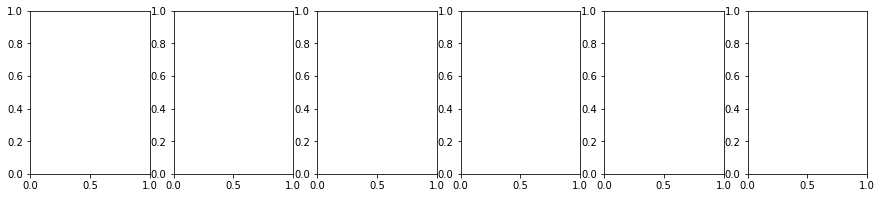

In [34]:
examples_num = 6

fig, axes = plt.subplots(ncols=examples_num, figsize=(15, 3), squeeze=True)

stride = 1000
for i, ax in enumerate(axes):
    ax.imshow(xaug[i + stride])
    ax.set_title("class-{0}".format(yaug[i + stride]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()

In [11]:
xnew = np.concatenate((X_train, xaug), axis=0)
ynew = np.concatenate((y_train, yaug), axis=0)

In [12]:

num_new = xnew.shape[0]

print("Total number of augmented training examples =", num_new)

Total number of augmented training examples = 78418


#### Histograms of new generated dataset

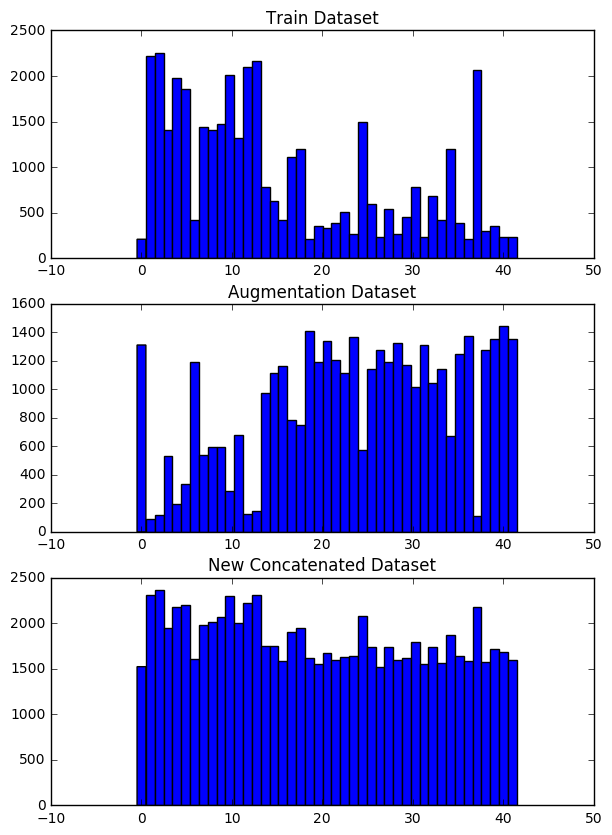

In [13]:
_, ax = plt.subplots(nrows=3, figsize=(7,10))
ax[0].hist(y_train, n_classes, normed=0, histtype='bar', align='left')
ax[1].hist(yaug, n_classes, normed=0, histtype='bar', align='left')
ax[2].hist(ynew, n_classes, normed=0, histtype='bar', align='left')
ax[0].set_title("Train Dataset")
ax[1].set_title("Augmentation Dataset")
_ = ax[2].set_title("New Concatenated Dataset")

Dataset description of new dataset shows that class fractions varies within **`1.8`% - `3.0`%** and this is enormous improvement.

In [14]:
descr_new = traffic_data.label_description(ynew)

pd.options.display.float_format = '{:.3%}'.format
display(descr_new)

class  count  percentage
0       2   2366      3.017%
1      13   2308      2.943%
2       1   2308      2.943%
3      10   2297      2.929%
4      12   2225      2.837%
5       5   2195      2.799%
6      38   2180      2.780%
7       4   2173      2.771%
8      25   2077      2.649%
9       9   2069      2.638%
10      8   2009      2.562%
11     11   1998      2.548%
12      7   1977      2.521%
13     18   1949      2.485%
14      3   1942      2.476%
15     17   1898      2.420%
16     35   1873      2.388%
17     31   1794      2.288%
18     14   1754      2.237%
19     15   1747      2.228%
20     26   1741      2.220%
21     33   1736      2.214%
22     28   1736      2.214%
23     40   1712      2.183%
24     41   1686      2.150%
25     21   1672      2.132%
26     24   1639      2.090%
27     36   1637      2.088%
28     23   1625      2.072%
29     30   1622      2.068%
30     19   1618      2.063%
31      6   1611      2.054%
32     22   1598      2.038%
33     42   1597      2.037%
34     29   1596      2.035%
35     37   1587      2.024%
36     16   1583      2.019%
37     39   1575      2.008%
38     34   1566      1.997%
39     20   1551      1.978%
40     32   1549      1.975%
41      0   1522      1.941%
42     27   1520      1.938%

#### Split dataset onto validation and training datasets accordingly and save all of them as tensorflow records

In [15]:
shapes = traffic_data.save_for_training(xnew, ynew, X_test, y_test,
                                        model_dir="tfdir",
                                        valid_size=0.1,
                                        override=False)
print("Shape of training dataset: x={0}, y={1}".format(shapes[0], shapes[1]))
print("Shape of validation dataset: x={0}, y={1}".format(shapes[2], shapes[3]))

Shape of training dataset: x=(70576, 32, 32, 3), y=(70576,)
Shape of validation dataset: x=(7842, 32, 32, 3), y=(7842,)


Train tensorflow record tfdir/data/train0.tfrecords already exists
Train tensorflow record tfdir/data/train1.tfrecords already exists
Train tensorflow record tfdir/data/train2.tfrecords already exists
Train tensorflow record tfdir/data/train3.tfrecords already exists
Valid tensorflow record tfdir/data/valid.tfrecords already exists
Test tensorflow record tfdir/data/test.tfrecords already exists


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My architecture completely based on ResNet and these three papers:

* https://arxiv.org/pdf/1512.03385v1.pdf
* https://arxiv.org/pdf/1603.05027.pdf
* https://arxiv.org/pdf/1502.03167v3.pdf

I researched how Residual Neural Network works and what makes it special. I devoted my time on learning **ResNet** and some optimization methods like **Batch normalization**, rather than finding suitable neural network model for _Traffic Sign Classification_ task. In other words, my target was not a getting better model for the challenge, but get more knowledge about current approaches in deep learning domain.

My network configuration consists of **4** blocks, each of them has **2** residual unit. Each residual unit represents a bottleneck stack of full pre-activated convolutional layers - first convolutional layer is 1x1 kernel map with N size input and M size output, second is 3x3 kernel map with M size input and M size output, and last one is 1x1 kernel map of M input size and M output size. It is worth to notice that N can be equal M. The `pre-activation` trick is quite good described in _"[Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)"_ paper. Both _Batch normalization_ and _shortcut_ links lead to the better traning behaviour and improve regularization of the model. For example, I even did not use dropout, but succeded **97%** of accuracy on test data after just first training round with small augmented data (less than < 10000 image samples was generated)

You can find my model related code at **resnet_arch.py** file. It has a class of ResNet architecture. It is defined in such way that you can change number of blocks, number of residual units per block, or dimentions of kernels.

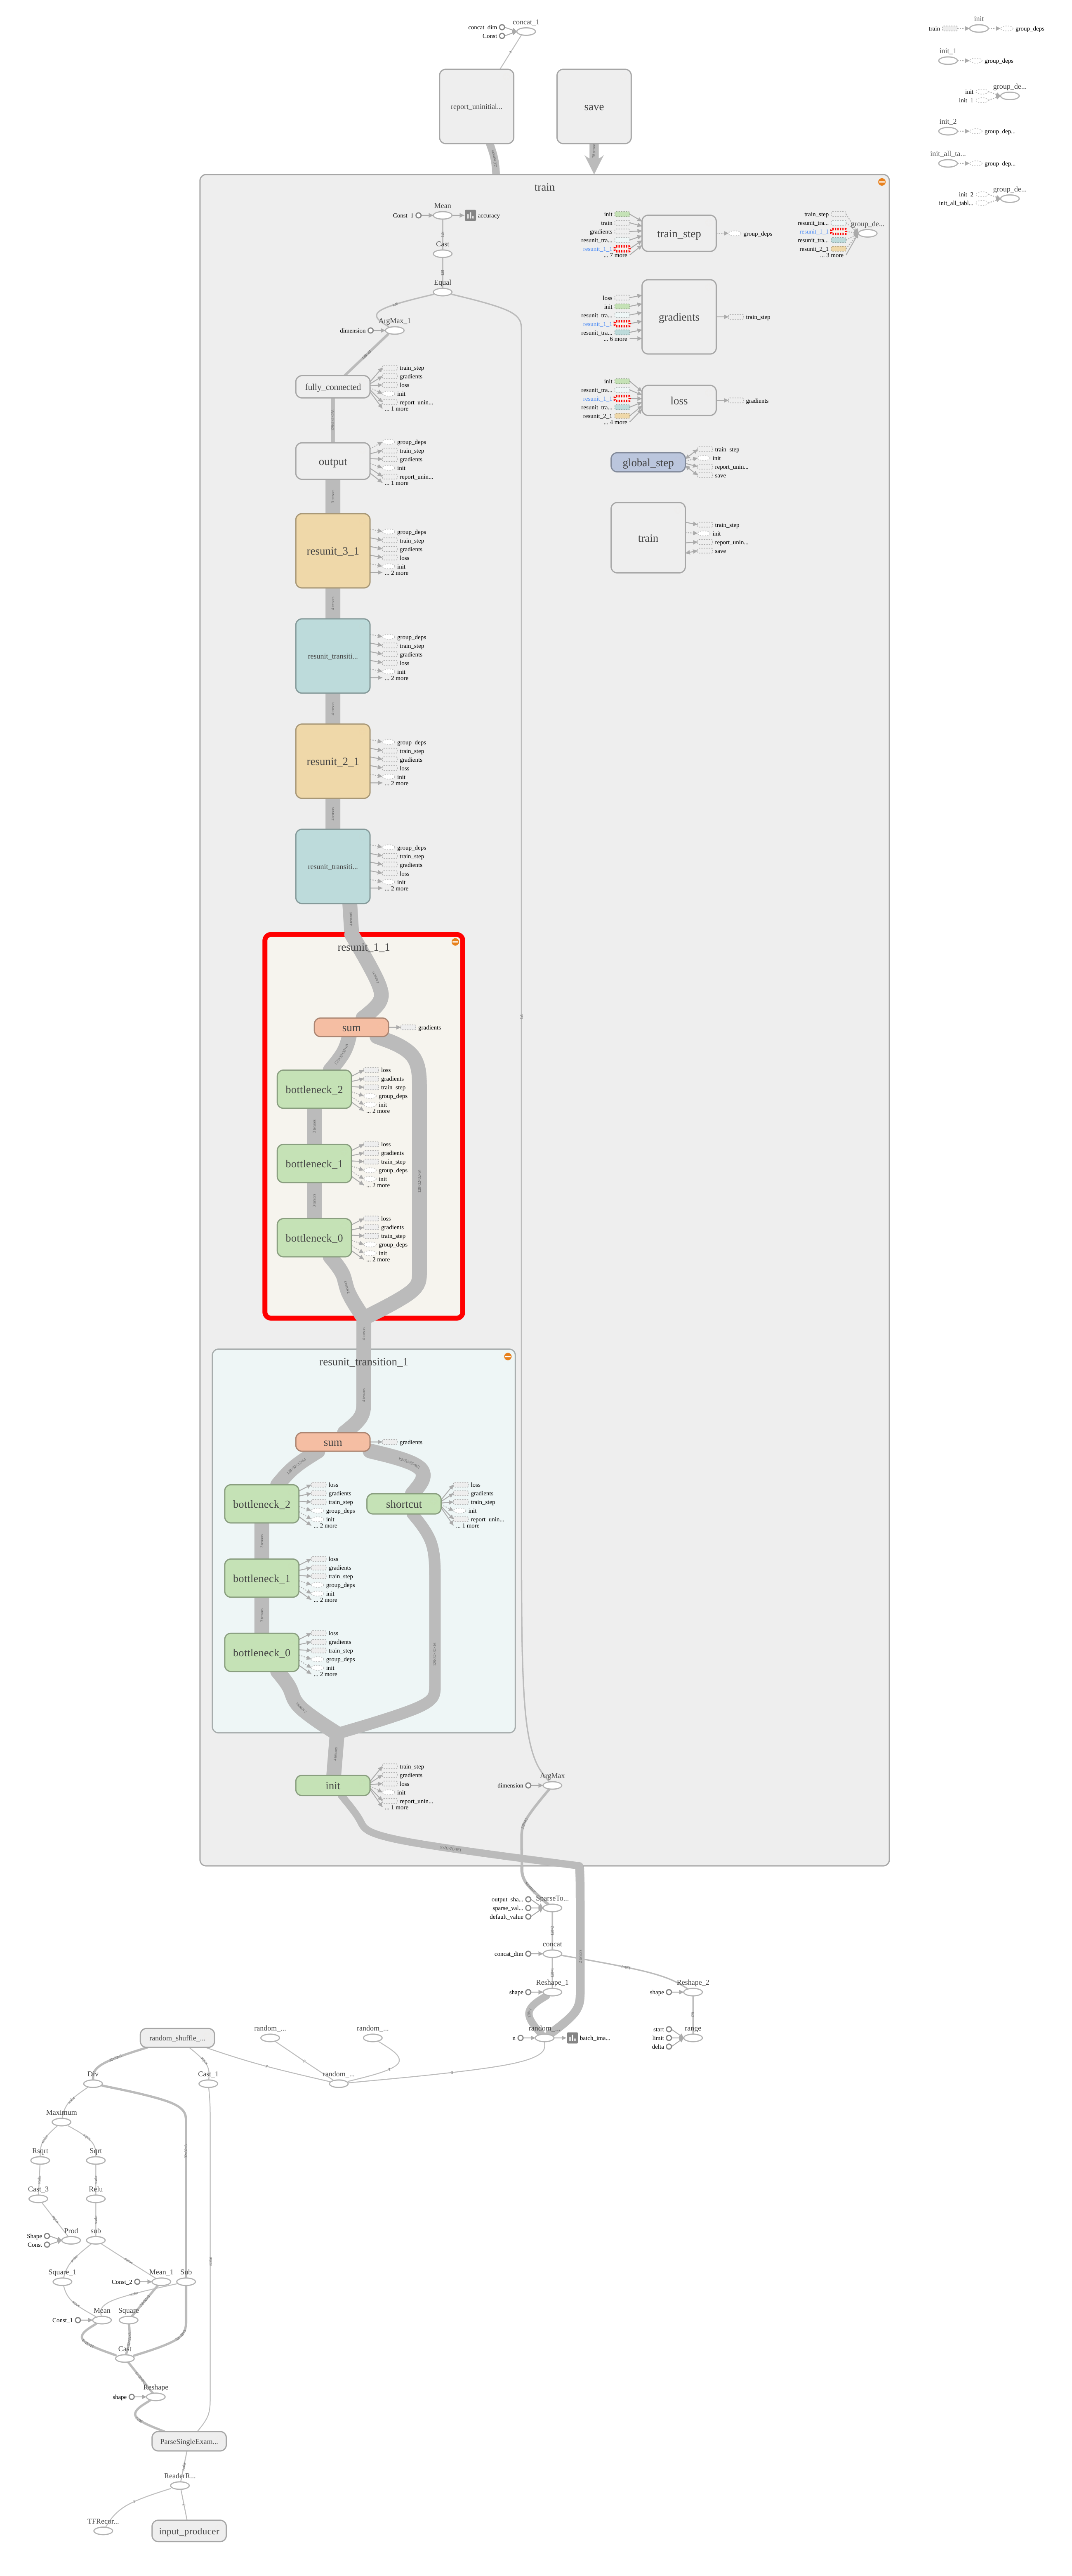

In [16]:
Image(filename="tfdir/model/graph.png")

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**

- **Type of optimizer**: Momentum SGD with `0.9` momentum term.
- **Batch size**: 128. The larger batch size increases time of training significantly.
- **Epochs**: I oriented on number of steps, rather than on epoch, but I terminated last training session on 35000th step. It is equivalent to 64 epochs.
- **Weight decay / L2 regularization**: weight decay rate, λ = 0.0003
- **Maps sizes**: [16, 64, 128, 256]
- **Loss function**: cross entropy
- **Learning rate**: first _10000_ steps α=0.1, until _15000_ step α=0.01, and after α=0.001, when number of steps approached _25000_, I changed rate to  α=0.0001

I made them default for **resnet** package.

In [17]:
import resnet

print(resnet.resnet_params())

nn_params(learning_rate=0.1, num_resunits_per_block=2, batch_size=128, num_labels=43, weight_decay_rate=0.0003, momentum_term=0.9, depths=[16, 64, 128, 256], image_shape=[32, 32, 3])


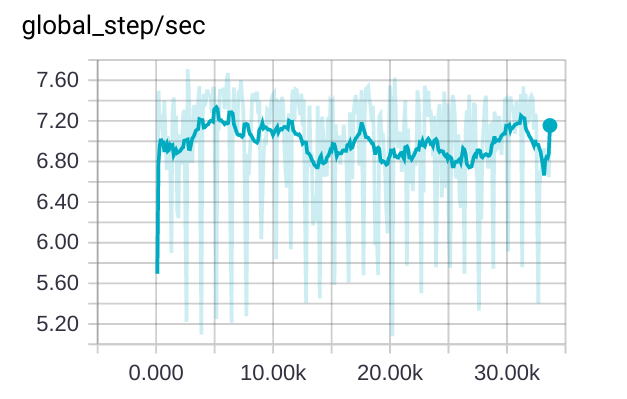

In [73]:
Image(filename="tfdir/model/global-step.png")

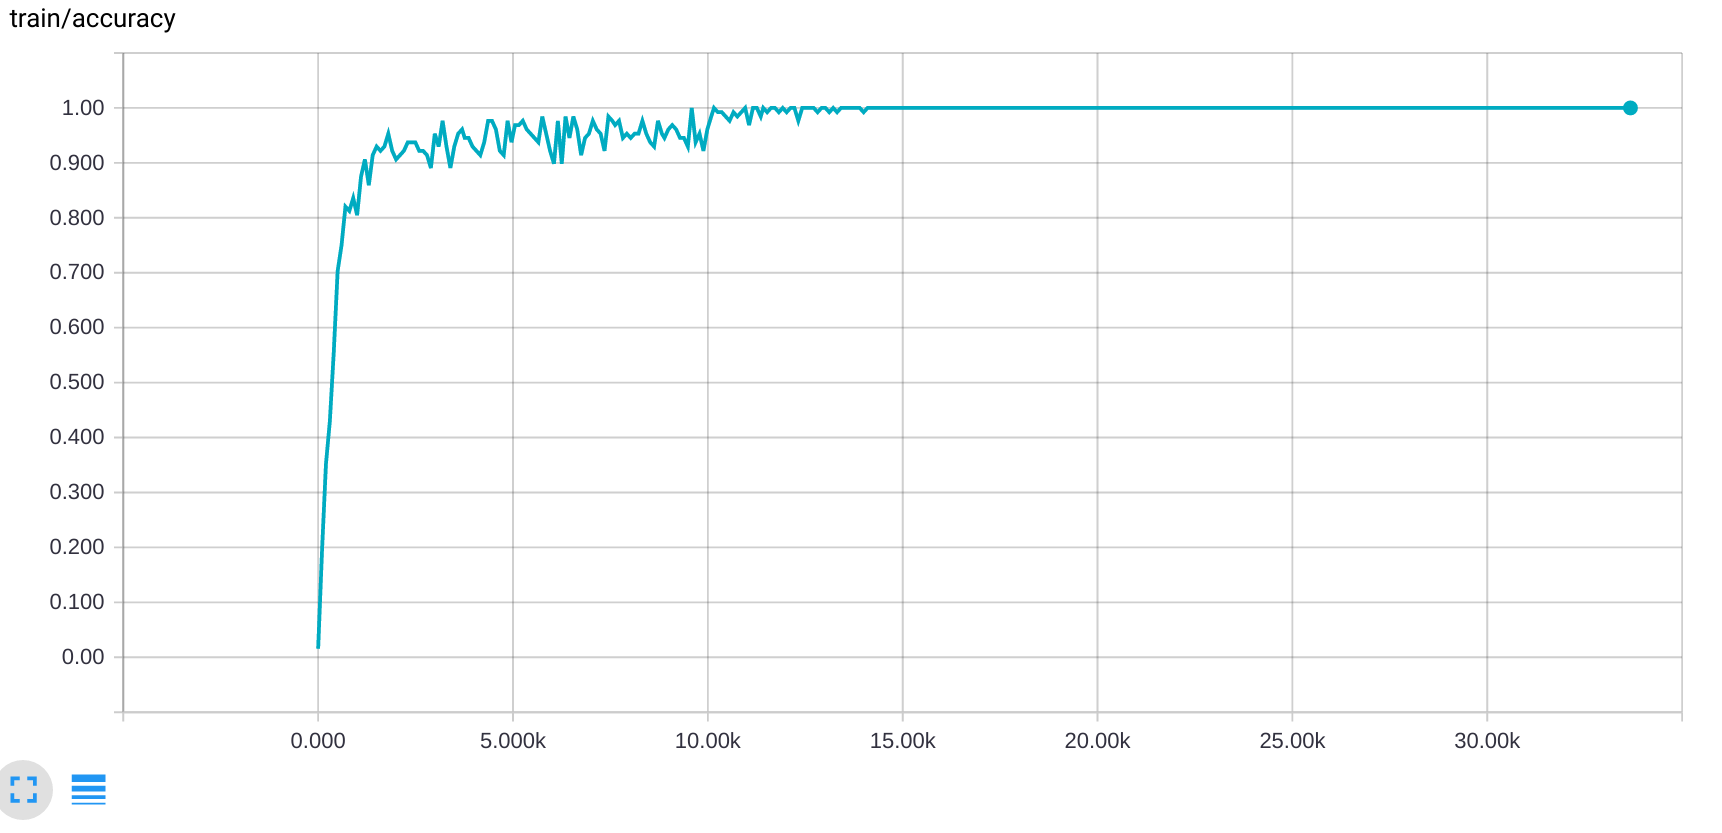

In [74]:
Image(filename="tfdir/model/train-accuracy.png")

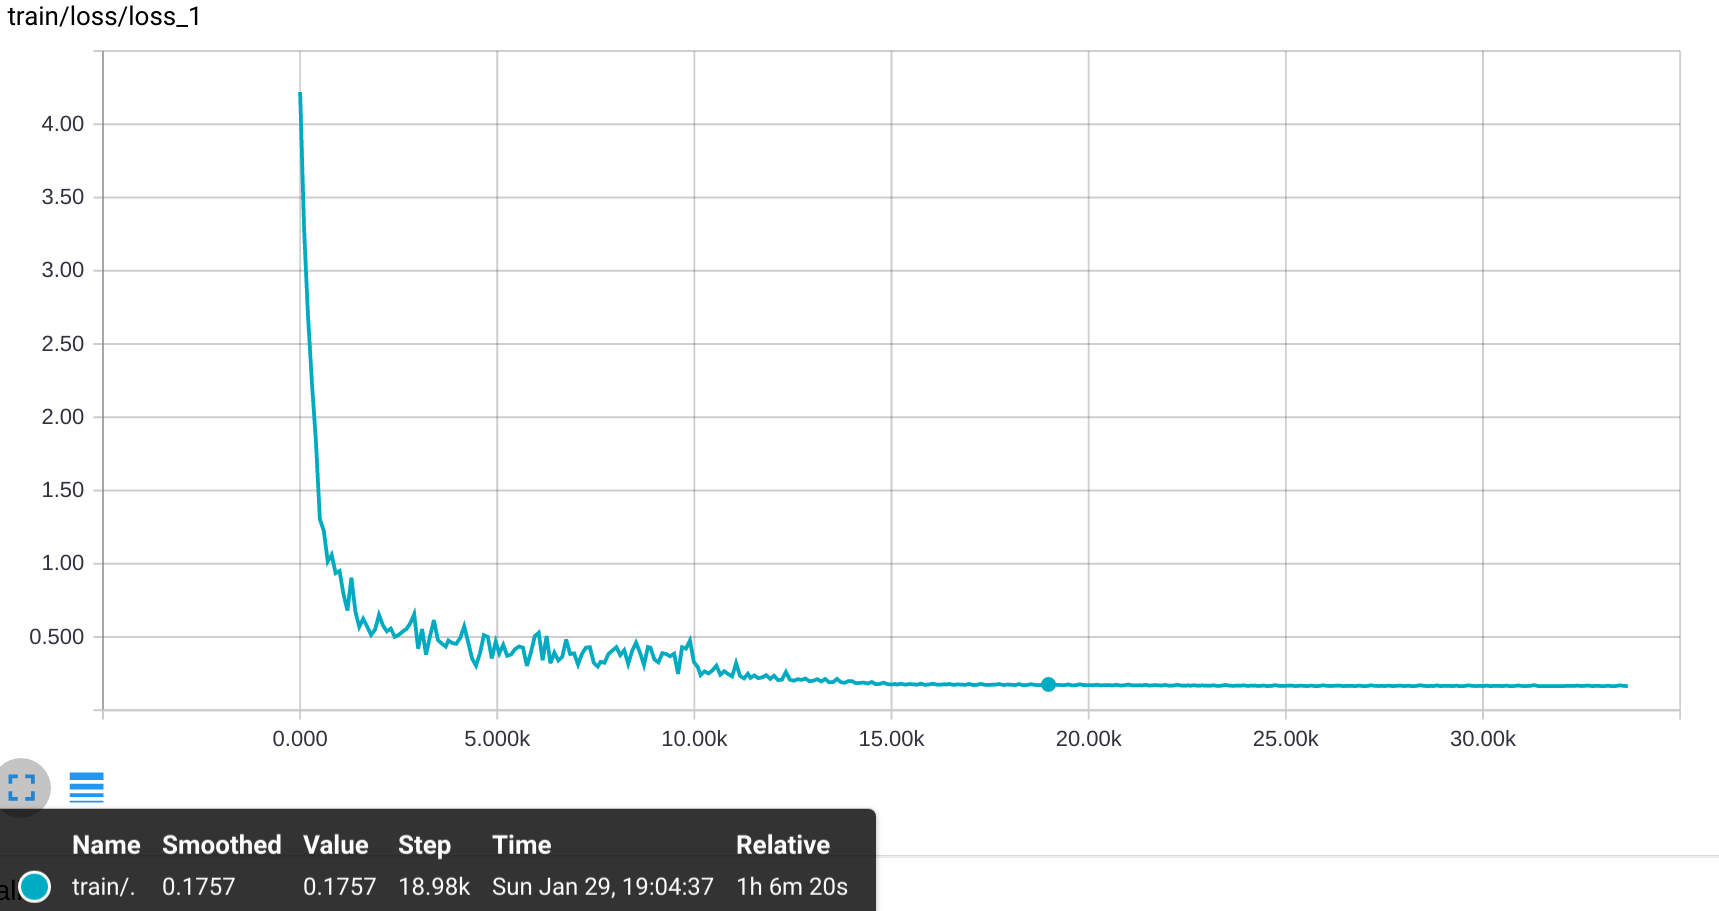

In [75]:
Image(filename="tfdir/model/train-loss.png")

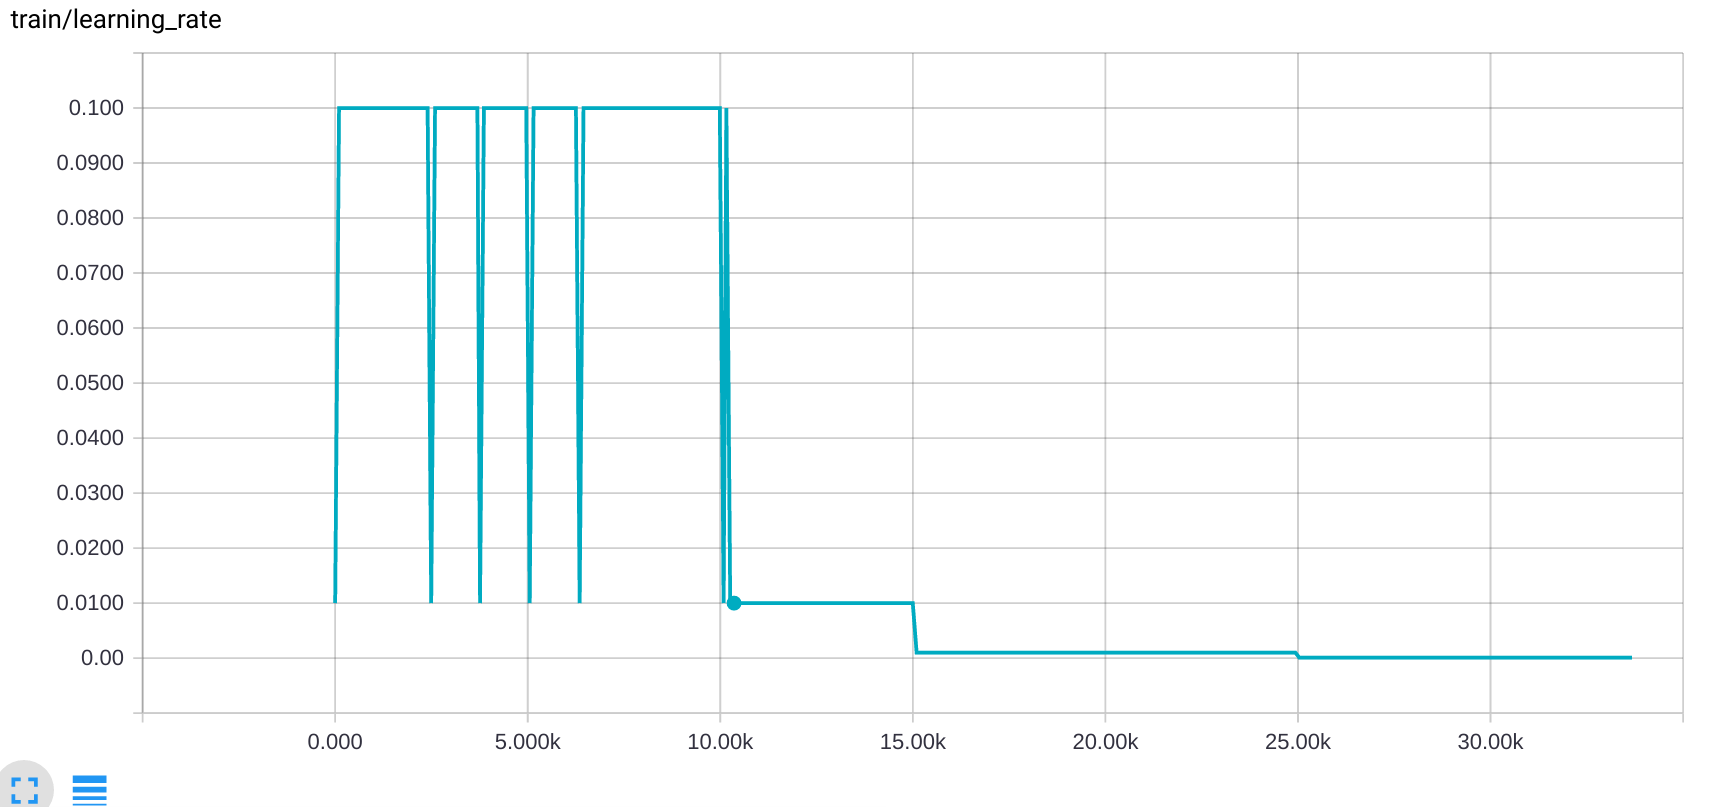

In [76]:
Image(filename="tfdir/model/train-learning-rate.png")

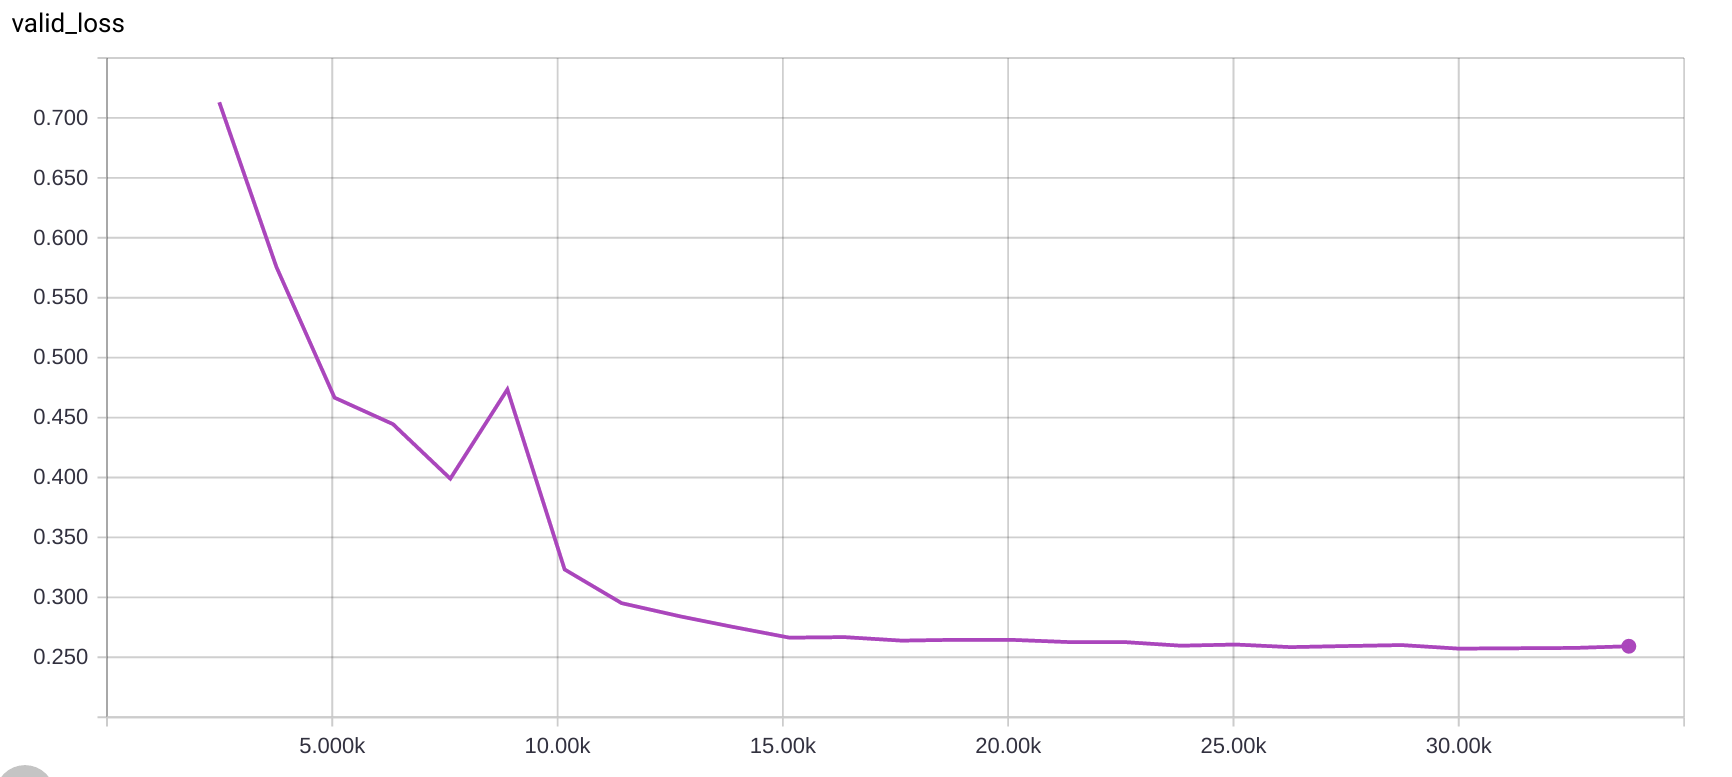

In [77]:
Image(filename="tfdir/model/valid-loss.png")

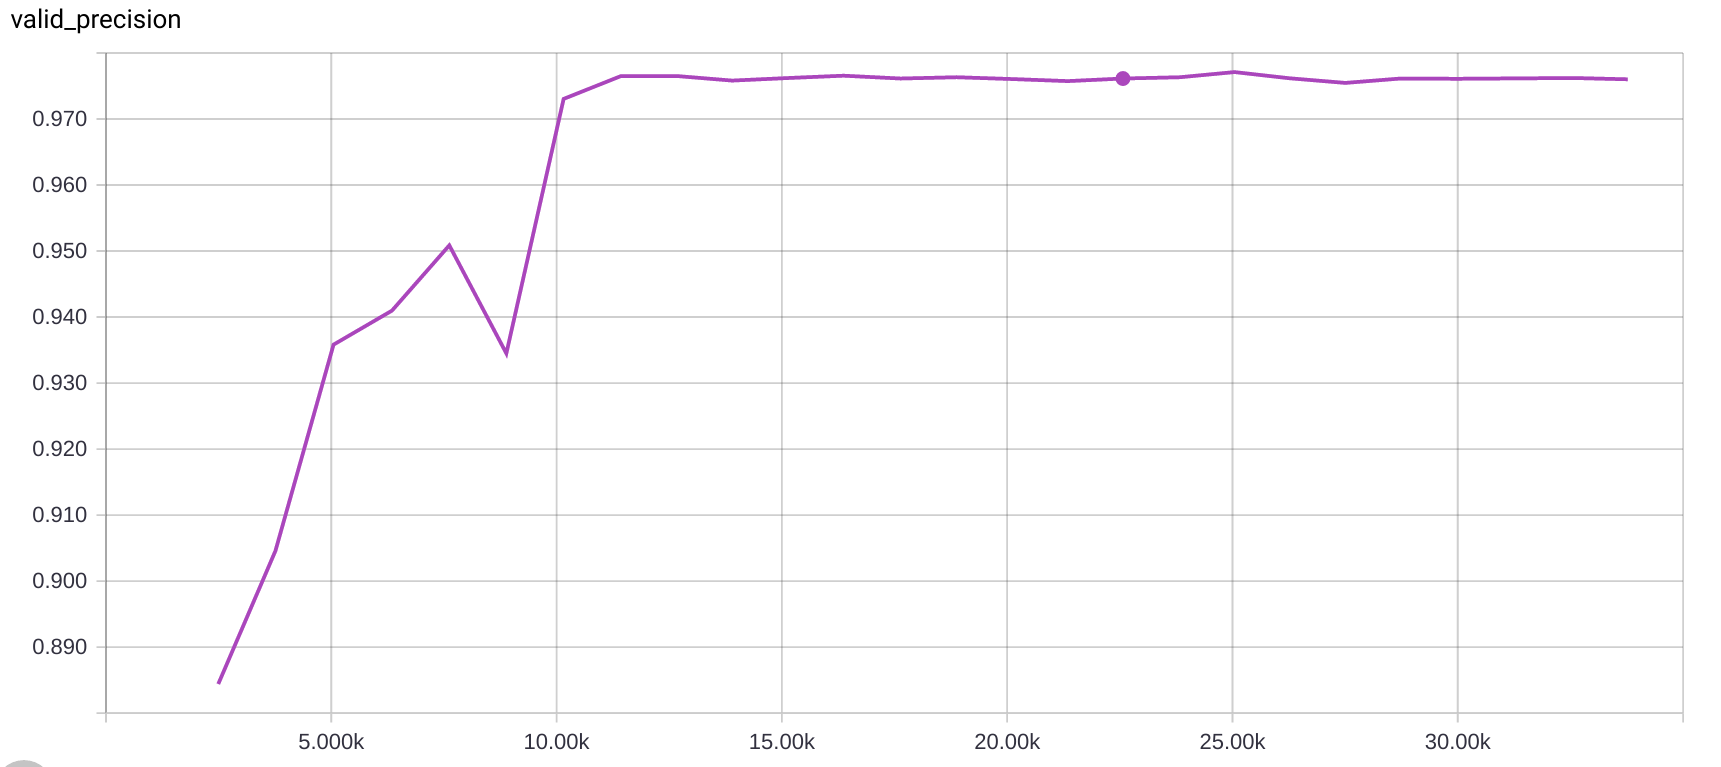

In [78]:
Image(filename="tfdir/model/valid-precision.png")

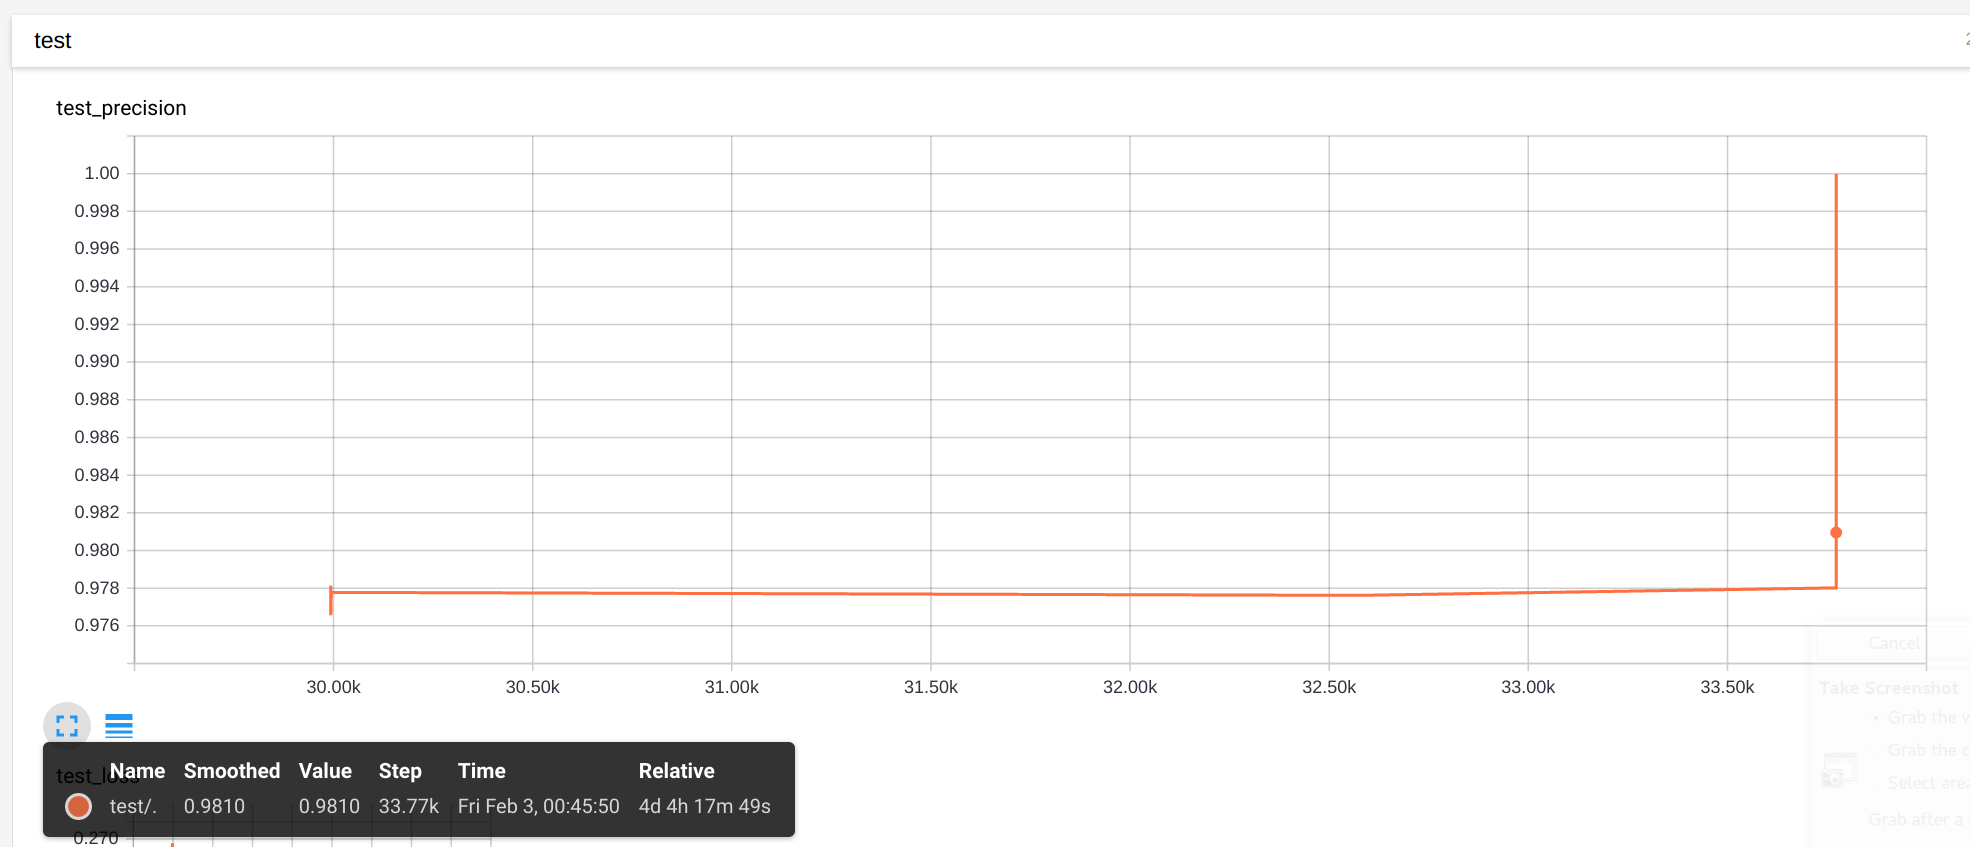

In [82]:
Image(filename="tfdir/model/test-accuracy.png")

## This should be plot with only one plot, although I tested different models with the same path
## tensorflow save it for me :)
## Final accuracy is 98.1%

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Research. Research. Research.

_Traffic Sign Classification_ is comparable to _MNIST_ or _CIFAR-10_ problem, so that many models which applied to these problems can be suitable to Udacity project as well. Because I have recently used _AlexNet_ on _MNIST_ dataset and [_Oxford Flowers_](http://www.robots.ox.ac.uk/~vgg/data/flowers/index.html) dataset, I was eager to try something else. Then I turn my mind on _ResNet_. Isn't it is a great opportunity to learn something new doing userful project for Udacity?

I got really awesome experience, even at the beginning I got `98.1%` accuracy on testing dataset. Learning process didn't take much time as well. I spent only _2_ hours of training and after that I couldn't see groundbreaking changes in loss value. The training and validation curves just reached their performance point without my intervention. So, I loved _ResNet_ even after first run :)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

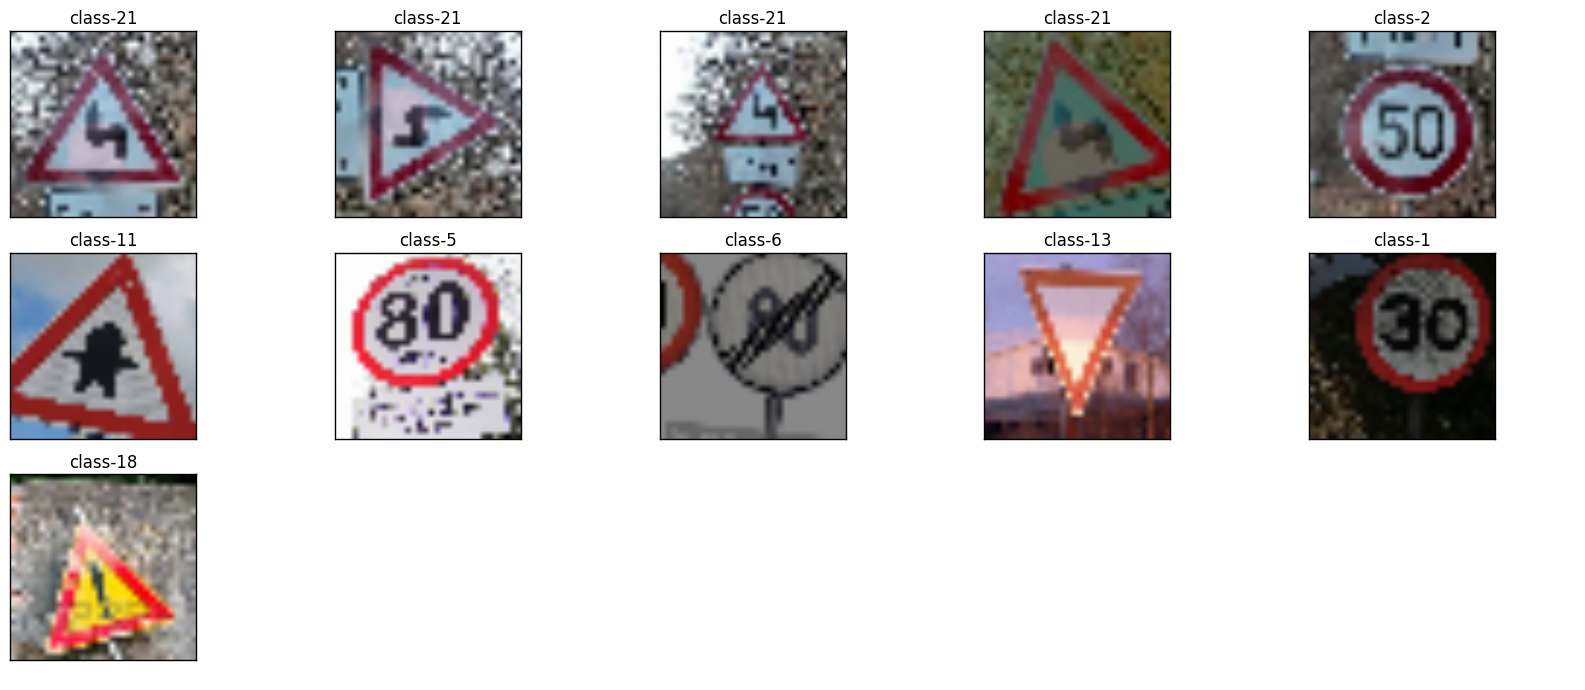

In [46]:
import pickle
import cv2 as cv

outside_images = "data/images.p"
with open(outside_images, "rb") as outside_images_file:
    images, labels = pickle.load(outside_images_file)

for i, _ in enumerate(images):
    images[i] = cv.cvtColor(images[i], cv.COLOR_BGR2RGB)

labels[-1] = 18
num_images = images.shape[0]
cols = num_images // 2
rows = num_images // cols + num_images % cols
figsize = (15, 7)

label_names = list(map(lambda i: "class-" + str(i), labels))

show_images(images, label_names, rows, cols, figsize)

In [33]:
signames_table = pd.DataFrame({"Sign Name": signames}, index=range(len(signames)))
display(signames_table)

Sign Name
0                                Speed limit (20km/h)
1                                Speed limit (30km/h)
2                                Speed limit (50km/h)
3                                Speed limit (60km/h)
4                                Speed limit (70km/h)
5                                Speed limit (80km/h)
6                         End of speed limit (80km/h)
7                               Speed limit (100km/h)
8                               Speed limit (120km/h)
9                                          No passing
10       No passing for vechiles over 3.5 metric tons
11              Right-of-way at the next intersection
12                                      Priority road
13                                              Yield
14                                               Stop
15                                        No vechiles
16           Vechiles over 3.5 metric tons prohibited
17                                           No entry
18                                    General caution
19                        Dangerous curve to the left
20                       Dangerous curve to the right
21                                       Double curve
22                                         Bumpy road
23                                      Slippery road
24                          Road narrows on the right
25                                          Road work
26                                    Traffic signals
27                                        Pedestrians
28                                  Children crossing
29                                  Bicycles crossing
30                                 Beware of ice/snow
31                              Wild animals crossing
32                End of all speed and passing limits
33                                   Turn right ahead
34                                    Turn left ahead
35                                         Ahead only
36                               Go straight or right
37                                Go straight or left
38                                         Keep right
39                                          Keep left
40                               Roundabout mandatory
41                                  End of no passing
42  End of no passing by vechiles over 3.5 metric ...

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._

**Answer:**

I chose 8 images and last one is not belong to any class from _Traffic Sign Dataset_. I took first one image - **class 21** and rotated it by 90 degree angle and got image at index `1`, zoomed it out twice and put it at index `2` and finally applied some color distortions - it got `3`th position. The rest of images remained unchanged. Total number of examples became `11`.

Obviously, the classificator should provide an error for unseen class image (last one in previous plot). I assigned `18` class to it - because, the only difference from German **18 "General caution"** sign is the backgroud inside red triangle - it is yellow. I anticipiated that this example will be wrong classified and, in fact, it was missclassified by my model.

I experimented a bit with different images and found one interesting thing: if you load image with OpenCV, the resulting colorful image is in BGR encoding by default, hence when you plot it you will see blueish image. I did this undeliberately and my trained model was mistook all bluish images for traffic signs that consist of blue color like **38 "Keep right"** or **34 "Turn left ahead"**. _After this discovery I think it is worth to try to learn model using **HSL/HSV** encoded images._

As disscussed in next paragraph, I noticed that classes like **30 "Beware of ice/snow"**, **27 "Pedestrians"**, **28 "Children crossing"** have details which can be vanished by noise, blurring or by simple small glare in the image. _I guess this problem can only be solved by bigger dataset with much samples especially for such signs_

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._

**Answer:**

Below, I plotted confusion matrix for testing dataset. Rows represent true classes and columns denote predicted classes. Tile on the map can be darker or lighter, the dark color indicates that most of the samples in this class were classified correctly, but it also means that there are a lot of examples in dataset for that class. If a tile is light colored and all of these samples got classified accurately, it illustrates shortage of the class.

Top-5 worst predicted classes in test dataset:

```
class-27 - precision is only 57.1%
class-21 - precision is quite low 71.4% too
class-30 - precision is 81.8%
class-25 - precision is more or less good, but still not perfect - 93%
class-18 - precision is 93.6%
```

**The class 27 "Pedestrians"** is tricky class, because it has a lot of details, in fact it is two humans and 32x32 image does not have a good resolution, so that humans on sign are too blurred.

**The class 21 "Double curve"** is very similar to **19 "Dangerous curve to the left"**, not for humans of course, although the trained model is biesed a bit to _19_ class when input is _21_. I used image found in Internet of _21_ class to test my classfier. The model predicted front image of the sign and zoomed version correctly. But it misclassified rotated image by 90 degree. Anyway it is expected result, as model has never been trained for such big rotation angle. It was surprising that introduced color fluctuation into the image and applied small rotation angle  led to wrong result - **31 "Wild animals crossing"**, however considering low resolution, low quality of trained images and relatively small dataset size, I suspect that the model couldn't find a good pattern for recognizing signs with some details during training.

**11 "Right-of-way at the next intersection"** example has the same issue as previous one. Just look at wrong predicted image in the next item, the predicted class is **30 "Beware of ice/snow"**. _30_ class is cast in the same mould as _11_, they differ from each other only by small details. 

Achieved accuracy on 10 images is **7/10 = 0.7 = 70%**.
> PS: I do not consider image of the class that doesn't fit to any class in _Traffic Sign Dataset_.

Of course this is not what you expect from model which gives you **98.1%** accuracy on testing data. But this is real tough world.

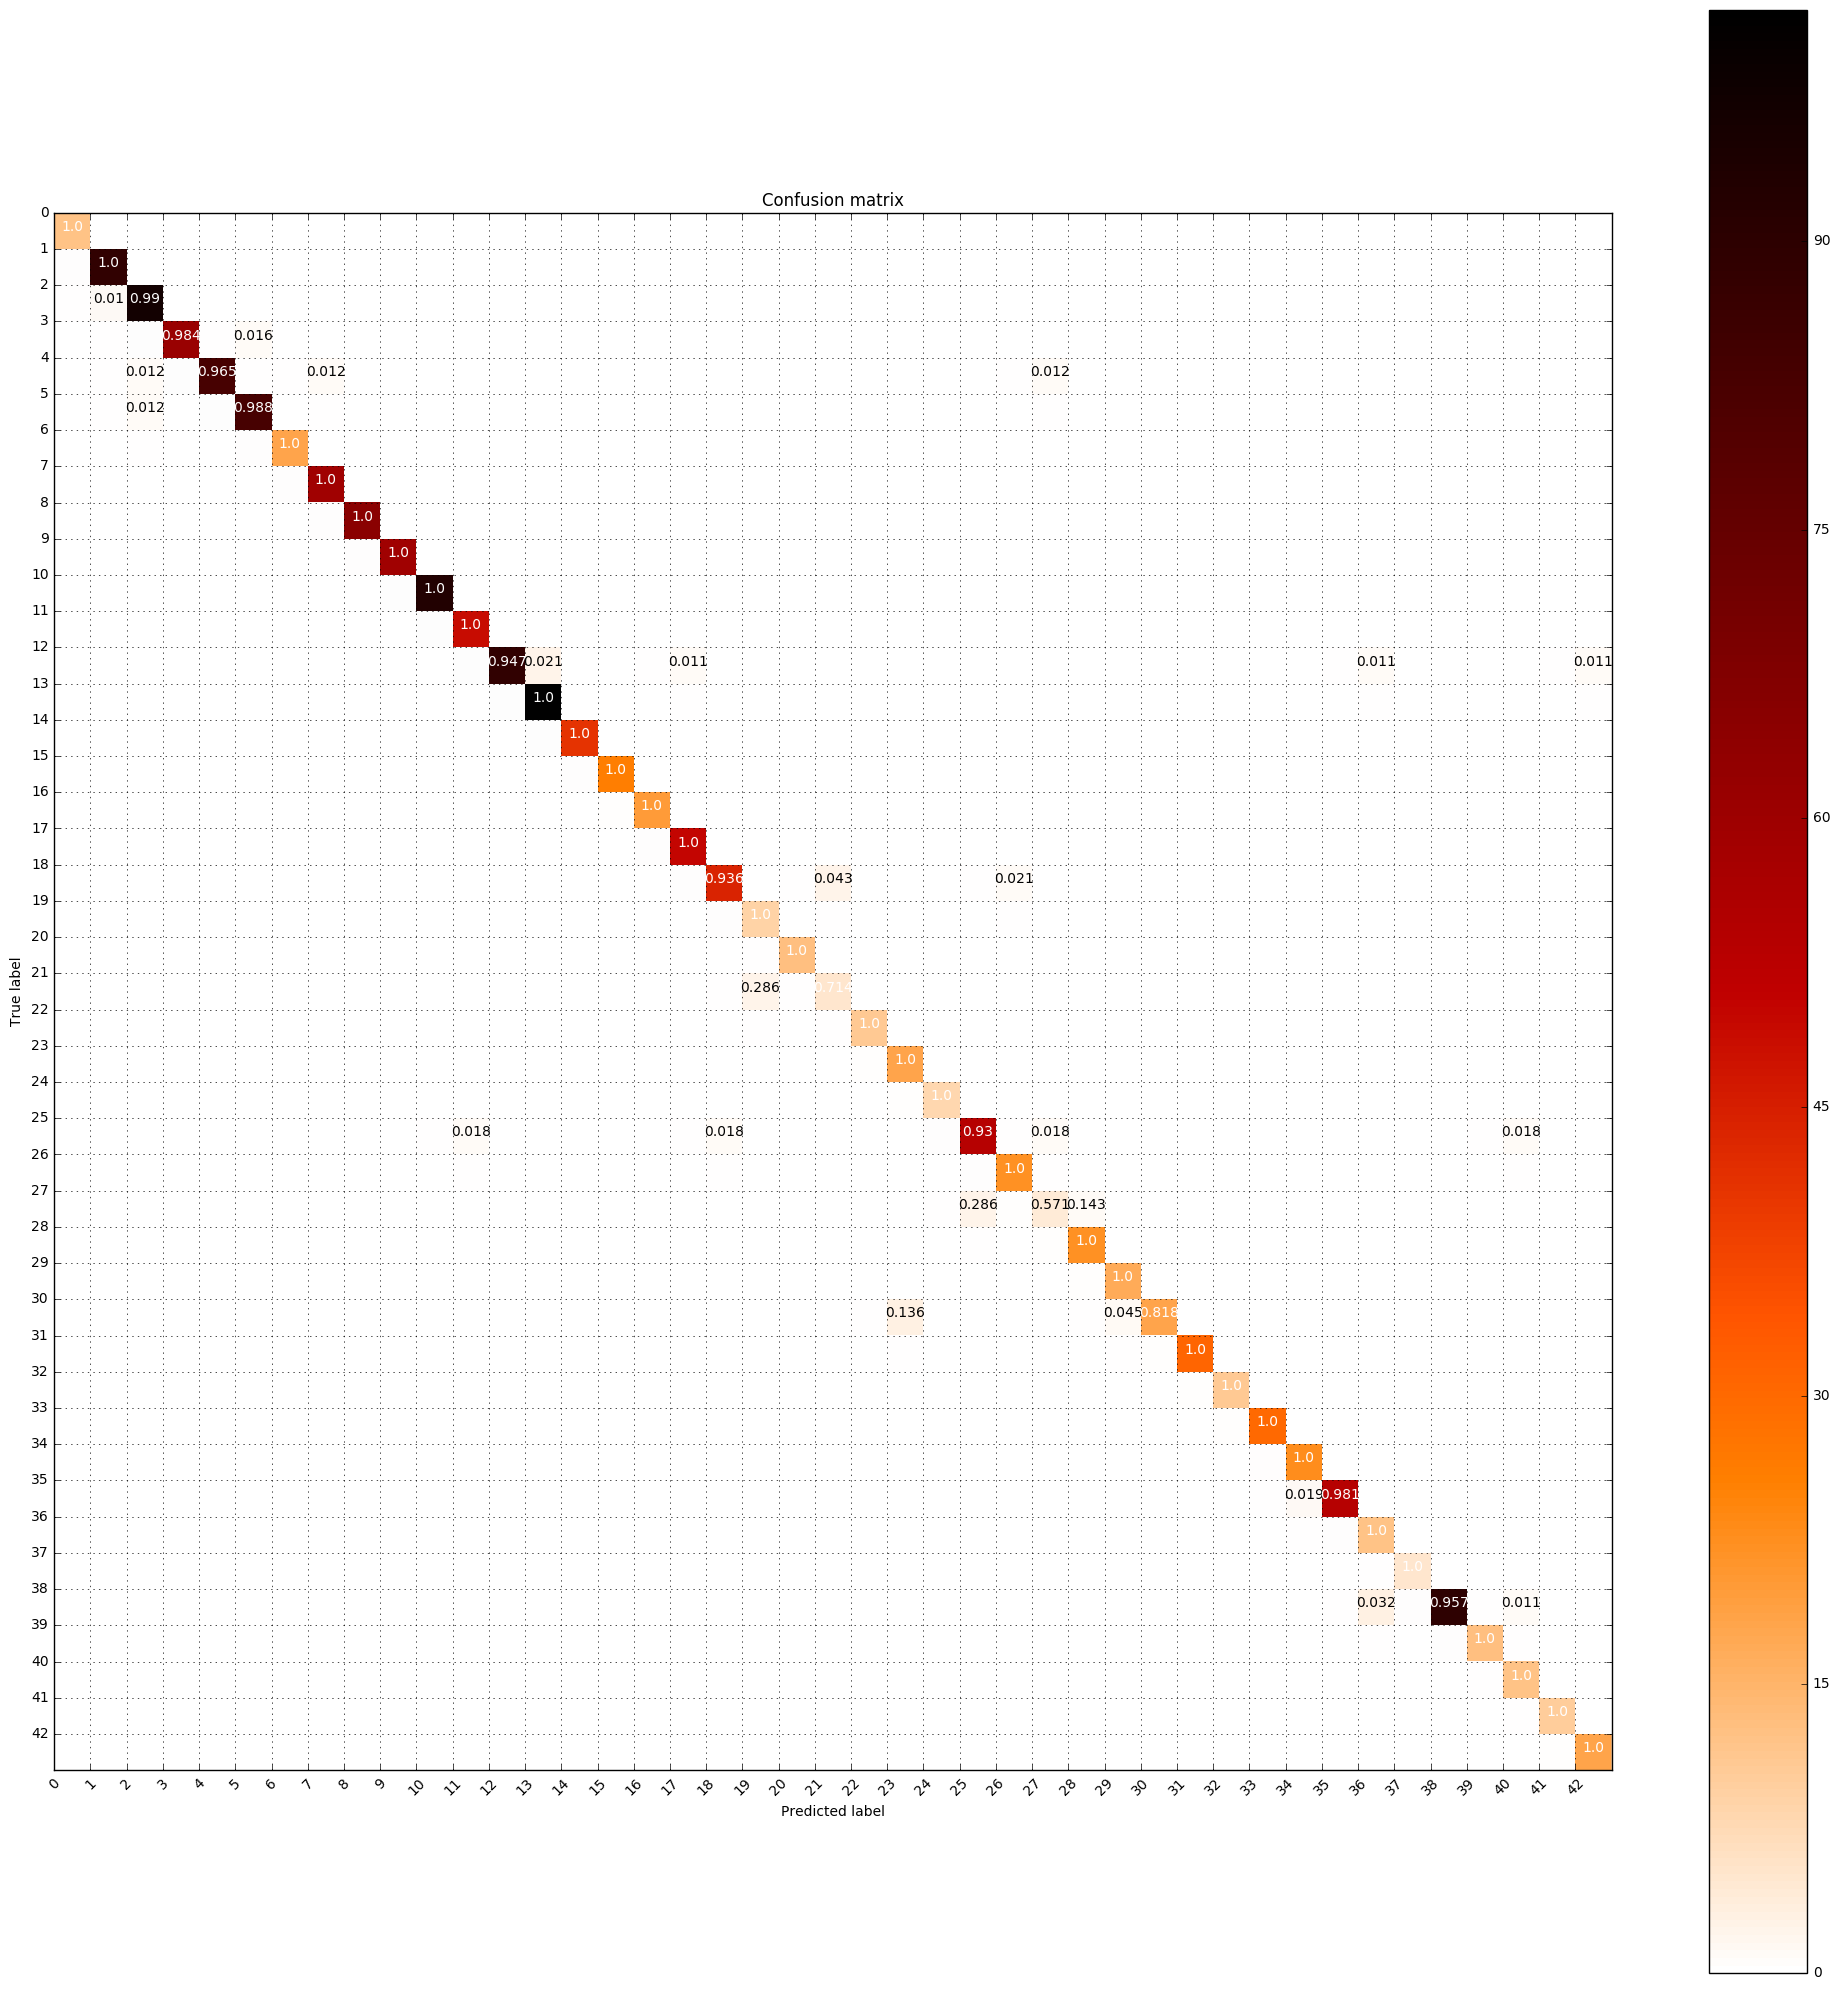

In [79]:
import itertools

cfm_src_file = "tfdir/model/confusion_matrix.p"
with open(cfm_src_file, "rb") as cfm_file:
    confusion_matrix = pickle.load(cfm_file)

def show_confusion_matrix(cfm, labels, normalize=True, title='Confusion matrix', cmap=plt.cm.gist_heat_r):
    plt.figure(figsize=(20,20))
    plt.grid(True)
    plt.imshow(cfm, interpolation='none', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks - 0.5, labels, rotation=45)
    plt.yticks(tick_marks - 0.5, labels)
    if normalize:
        cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
    thresh = cfm.max() / 1.5
    for i, j in itertools.product(range(cfm.shape[0]), range(cfm.shape[1])):
        if cfm[i, j] != 0:
            plt.text(j, i, np.round(cfm[i, j], 3), horizontalalignment="center",
                     color="white" if cfm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    top_prec = np.sort(cfm, axis=1).T[::-1][0]
    top = 10
    top_10 = (np.argsort(top_prec)[:top], np.sort(top_prec)[:top])
    return top_10
    
top_10 = show_confusion_matrix(confusion_matrix, range(n_classes))

In [72]:
top_10_table = pd.DataFrame({"Class Index": top_10[0], "Precision": top_10[1]})
display(top_10_table)

Class Index  Precision
0           27    57.143%
1           21    71.429%
2           30    81.818%
3           25    92.982%
4           18    93.617%
5           12    94.681%
6           38    95.745%
7            4    96.512%
8           35    98.148%
9            3    98.387%

In [44]:
import os
import resnet
import traffic_data
import tensorflow as tf

model_dir = "tfdir/model/train/"

inferences = []
top_5s = []

tfrecord = "testrecord"
tfrecord_file = tfrecord + ".tfrecords"
cwd = os.getcwd()
for i in range(num_images):
    tf.reset_default_graph()
    traffic_data.save_as_tfrecords(np.array([images[i]]), np.array([labels[i]]), tfrecord_file)
    ##########################################################
    #### Let's run saved Tensorflow model on input test images
    ##########################################################
    inference = resnet.single_test(tfrecord, ".", model_dir)
    inference = inference[0]
    inferences.append(inference)
    top_5 = list(zip(np.argsort(inference)[::-1], np.sort(inference)[::-1]))[:5]
    top_5s.append(top_5)

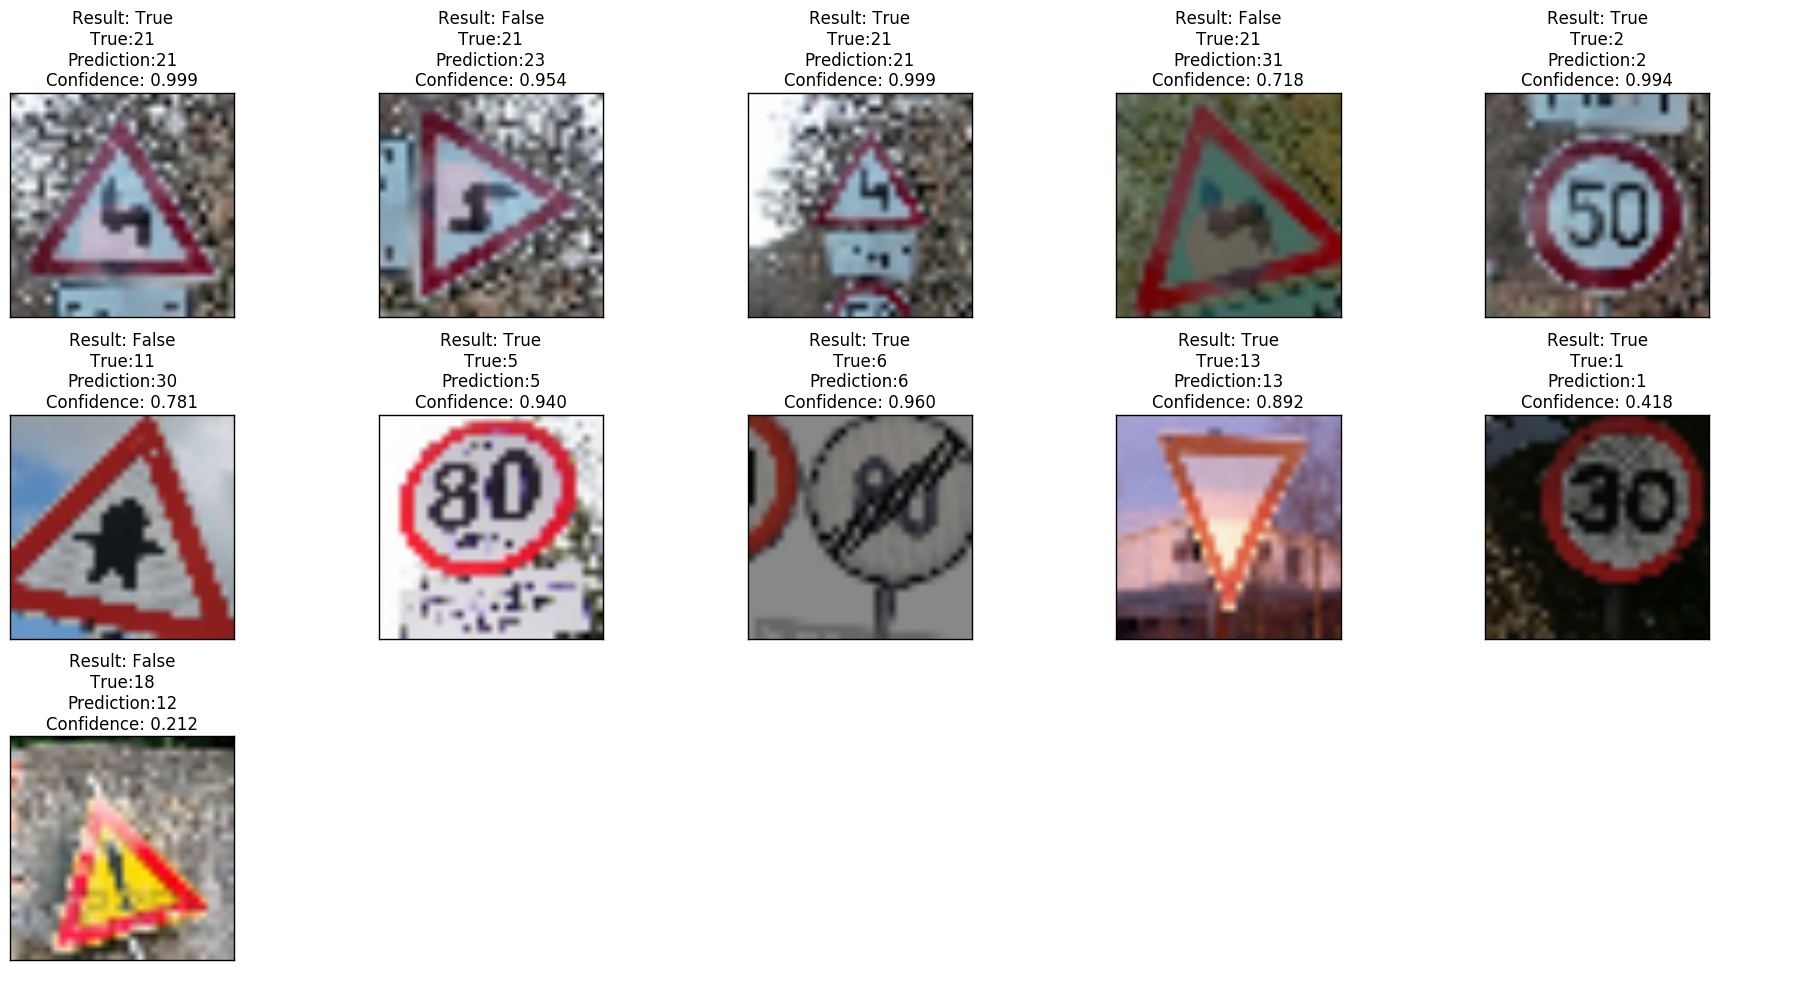

In [45]:
def format_annotation(res, label):
    return "Result: {0}\nTrue:{1}\nPrediction:{2}\nConfidence: {3:.3f}".format(
        res[0] == label,
        label,
        res[0],
        res[1]
    )
annotations = list(map(lambda i: format_annotation(top_5s[i][0], labels[i]), range(num_images)))
figsize=(17, 10)
show_images(images, annotations, rows, cols, figsize)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

I didn't use `tf.nn.top_k`, I suppose it is more userful to see Softmax distribution over all classes rather than only 5. in the next block you can see rows with input image and discrete probabilities for the image, which is some sort of weighted vote for each output class.

Each bar represents the probability of certain class, you can notice label above it. Green bar is true class, if it is highest bar among all others and there is no red bar on the chart then it means that image example is predicted properly. Accordingly if highest bar is red then a prediction mismatches true value.

> PS: It is a bit boring to consider strongly predicted images, I would like to concentate on false positives.

  Let's start with second row, the model firmly believes that class for `image-1` should be **23 "Slippery road"**, but this is wrong and true class must be **21 "Double curve"**.  
  `image-5` are classified wrongly with ~`0.8` likelihood, but the model paid attention to true class with ~`0.2` probability as well.  
  Most interesting inference related to most frequent traffic sign in `image-9` in training dataset - **1 "Speed limit (30km/h)"**. Despite the fact that the label predicted correctly, the model hesitates between three classes: **5 "Speed limit (80km/h)"**, **2 "Speed limit (50km/h)"** and **0 "Speed limit (20km/h)"**. The prediction probability for true class is only `0.4`, whereas prediction for _5_ is about `0.3`. That's really short gap. And I suppose, it happens because of likeness of number three and eight.

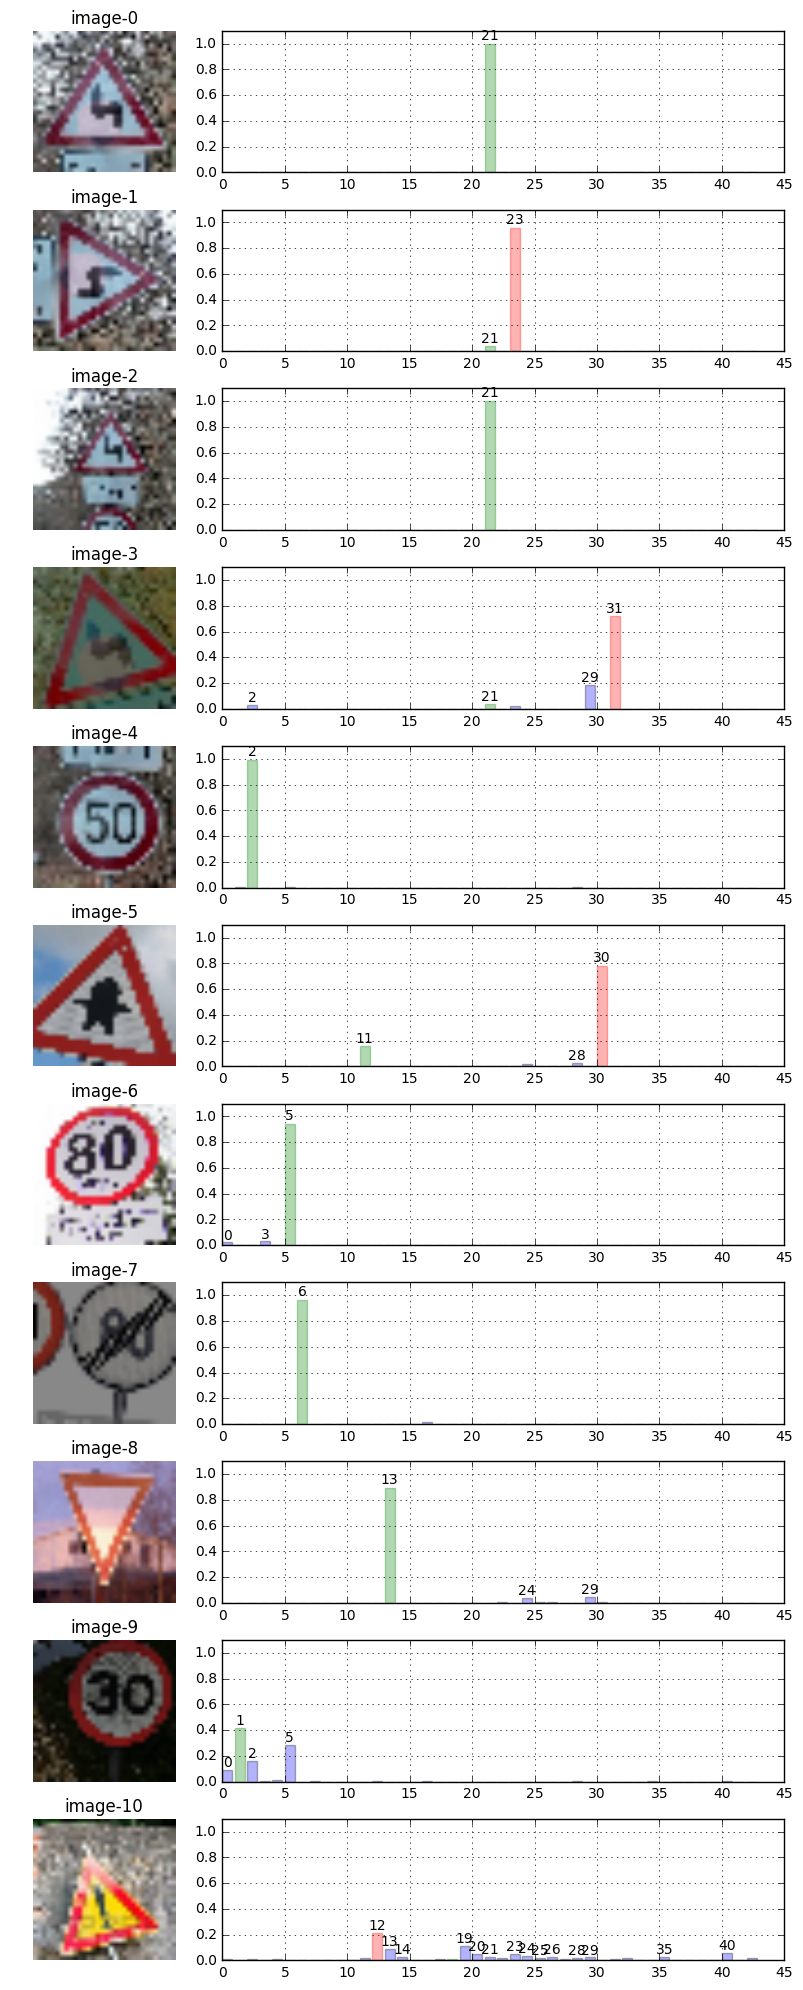

In [116]:

bar_height_limit = 0.02
fig, axes = plt.subplots(nrows=num_images, ncols=2, squeeze=True, figsize=(10,20))
image_names = ["image-{0}".format(i) for i in range(num_images)]
for i in range(num_images):
    ax = axes[i]
    ax[0].axis("off")
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(True)
    ax[0].imshow(images[i])  
    ax[0].set_title(image_names[i])
    rects = ax[1].bar(range(len(inferences[i])), inferences[i], color="b", alpha=0.3)
    ax[1].grid(True)
    ax[1].set_ylim([0,1.1])
    true_id = labels[i]
    pred_id = top_5s[i][0][0]
    rects[true_id].set_color('g')
    if pred_id != true_id:
        rects[pred_id].set_color('r')
    for r, rect in enumerate(rects):
        height = rect.get_height()
        if height <= bar_height_limit:
            continue
        ann = "{0}".format(r)
        ax[1].text(rect.get_x() + rect.get_width()/2., 
                   1.01 * height, ann, ha='center', va='bottom')

fig.subplots_adjust(wspace=0, left=-0.1)
fig.tight_layout(w_pad=0)

In [177]:
columns = np.arange(0, 10, 2)
column_names = []
t = 1
for i in range(5 * 2):
    if i % 2 == 0:
        column_names.append("top-{0}/class".format(t))
    else:
        column_names.append("top-{0}/acc".format(t))
        t += 1

## If it could be a R language this expression would look better :)
top_5s_table = pd.DataFrame([list(np.array(list(map(lambda r: [r[0], r[1]], t))).flat) for t in top_5s])
top_5s_table[columns] = top_5s_table[columns].astype(int)
top_5s_table.columns = column_names
top_5s_table.index = image_names

pd.options.display.float_format = '{:.5%}'.format
display(top_5s_table)

top-1/class  top-1/acc  top-2/class  top-2/acc  top-3/class  \
image-0            21  99.94030%           31   0.03912%            2   
image-1            23  95.41949%           21   4.31921%           28   
image-2            21  99.85033%            2   0.06360%           31   
image-3            31  71.81113%           29  18.31939%           21   
image-4             2  99.36317%            1   0.29460%           28   
image-5            30  78.07942%           11  15.60679%           28   
image-6             5  93.99465%            3   2.92375%            0   
image-7             6  96.00231%           16   1.55681%           32   
image-8            13  89.16283%           29   4.59777%           24   
image-9             1  41.76812%            5  28.37510%            2   
image-10           12  21.21349%           19  11.20450%           13   

          top-3/acc  top-4/class  top-4/acc  top-5/class  top-5/acc  
image-0    0.00629%           23   0.00582%           19   0.00347%  
image-1    0.08865%           19   0.06645%           25   0.03359%  
image-2    0.05863%           29   0.01142%           38   0.00222%  
image-3    3.99575%            2   3.23200%           23   1.82145%  
image-4    0.11352%            5   0.07923%           12   0.04830%  
image-5    2.77974%           24   1.57567%           27   0.41570%  
image-6    2.15950%            2   0.51506%           28   0.19902%  
image-7    0.35513%           41   0.30754%            3   0.28255%  
image-8    3.66109%           26   0.76909%           25   0.73769%  
image-9   15.79506%            0   9.29639%            4   1.60588%  
image-10   8.70751%           40   5.53107%           20   5.31103%